In [1]:
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.stats import smetrics
# from preproc_tools import get_fr_by_sample
import numpy as np
#import compute_population_distance
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from ephysvibe.stats import smetrics

In [2]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
x = np.array([[2, 0, 2], [2, 2, 3]])
x.shape

(2, 3)

In [4]:
u=[1,0]
v=[-1,1]
print(x)
print(pdist(x,metric='cosine'))

[[2 0 2]
 [2 2 3]]
[0.14250707]


In [5]:
distance.cosine(x[0],x[1])

0.1425070742874559

In [15]:
A = np.array([[1, 0,]])
B = np.array([[0, -1]])

In [16]:
cosine_similarity(A,B)

array([[0.]])

In [22]:
(((1-cosine_similarity(A,B))/2)*np.pi)*360/(2*np.pi)

array([[90.]])

In [6]:
pdist(x,metric='euclidean')

array([2.23606798])

### Start preprocessing

In [5]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'min_sp_sec' : 1,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [6]:
import pandas as pd
import preproc_tools
seed=1997

In [7]:
def compute_distance(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    rng = np.random.default_rng(seed)
    res = {}

    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        preproc_tools.get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]

    print("start iterations")
    distance_data = []
    for _ in tqdm(range(1000)):
        dist = get_distance(
            fr_dicts_only,
            rng=rng,
            min_trials=min_trials,
            select_n_neu=select_n_neu,
            metric=metric,
        )
        distance_data.append(dist)

    all_dist_n_nn = []
    all_dist_fake_n_nn = []
    for asc in distance_data:
        all_dist_n_nn.append(asc["dist_n_nn"])
        all_dist_fake_n_nn.append(asc["dist_fake_n_nn"])
    all_dist_n_nn = np.array(all_dist_n_nn, dtype=np.float32)
    all_dist_fake_n_nn = np.array(all_dist_fake_n_nn, dtype=np.float32)
    res["dist_n_nn"] = all_dist_n_nn
    res["dist_fake_n_nn"] = all_dist_fake_n_nn
    res["n_neurons"] = asc["n_neurons"]

    res = Results("population_distance.py", input, distance=res)
    return res

In [8]:

def scrum_neutralsize_samepool(data, ntr, rng):

    nn = np.concatenate((data["11"], data["15"], data["51"], data["55"]), axis=0)
    size_nn = nn.shape[0]

    idx_tr = rng.choice(size_nn, size=ntr, replace=False)
    nn_trs = nn[idx_tr]

    idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
    neutral_trs = data["0"][idx_tr]

    meanfr0 = np.mean(neutral_trs, axis=0)
    meanfr11 = np.mean(nn_trs, axis=0)
    meanfr15 = np.mean(nn_trs, axis=0)
    meanfr51 = np.mean(nn_trs, axis=0)
    meanfr55 = np.mean(nn_trs, axis=0)

    all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

    idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [9]:
def get_distance(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []
    if metric == 'cosine':
        model = PCA(n_components=select_n_neu).fit(reshape_pc.reshape(select_n_neu,-1).T)
        C = model.components_
        reshape_pc = reshape_pc - C.reshape(-1,1,1)


    for i in range(reshape_pc.shape[-1]):

        dist_n_nn.append(
            pdist(np.array((reshape_pc[:, 0, i], reshape_pc[:, 1, i])), metric=metric)
        )
        dist_fake_n_nn.append(
            pdist(np.array((fr_groups[:, 0, i], fr_groups[:, 1, i])), metric=metric)
        )

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


Compute distances


100%|██████████| 530/530 [00:08<00:00, 63.13it/s]


start iterations


  0%|          | 0/1000 [00:00<?, ?it/s]

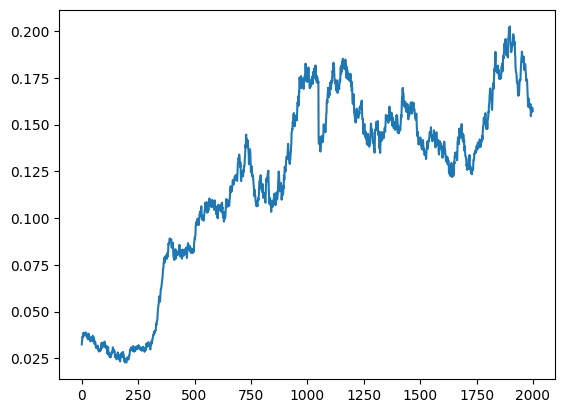

  0%|          | 0/1000 [07:02<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (100,2,2000) (10000,1,1) 

In [11]:
res = compute_distance(**preprocessing, **paths)

In [21]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p

In [22]:
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

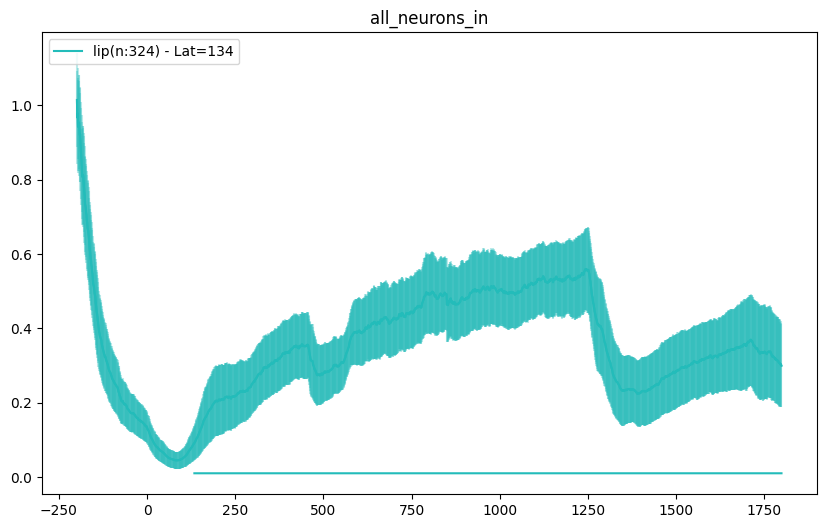

In [24]:
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip']):
    d=res.distance['dist_n_nn']
    fd=res.distance['dist_fake_n_nn']

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200

    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('all_neurons_in')